# fastai

This notebook is once again based on johnowhitaker's blog post found [here](https://datasciencecastnet.home.blog/2019/10/21/zindi-uberct-part-2-stepping-up/).

In [ ]:
#because we're on google colab
!pip install --upgrade pandas
!pip install --upgrade geopandas
!pip install --upgrade sklearn

In [10]:
#load the modules that make the magic possible
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [11]:
from fastai.tabular import *
from sklearn.metrics import log_loss, f1_score

In [ ]:
# mount google drive as a file system
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [13]:
path = Path('/content/gdrive/My Drive/Zindi_Accident')

#### Load data

In [ ]:
#load the train and test
train = pd.read_csv(path/'data/train_with_weather_vds.csv', sep = ';', parse_dates = ['datetime'])
test = pd.read_csv(path/'data/test_with_weather_vds.csv', sep = ';', parse_dates = ['datetime'])

In [16]:
print(train.shape)
print('')
print(test.shape)

(4800043, 24)

(1588346, 24)


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800043 entries, 0 to 4800042
Data columns (total 24 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime x segment_id  object        
 1   datetime               datetime64[ns]
 2   segment_id             object        
 3   y                      int64         
 4   year                   int64         
 5   month                  int64         
 6   day                    int64         
 7   hour                   int64         
 8   longitude              float64       
 9   latitude               float64       
 10  WIDTH                  float64       
 11  LANES                  int64         
 12  STATION_NA             object        
 13  Air_temp               float64       
 14  Atmos_press            float64       
 15  Atmos_press_MeanSea    float64       
 16  Humidity               float64       
 17  MeanWindSpeed          float64       
 18  Visibility            

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1588346 entries, 0 to 1588345
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   datetime x segment_id  1588346 non-null  object        
 1   datetime               1588346 non-null  datetime64[ns]
 2   segment_id             1588346 non-null  object        
 3   y                      1588346 non-null  int64         
 4   year                   1588346 non-null  int64         
 5   month                  1588346 non-null  int64         
 6   day                    1588346 non-null  int64         
 7   hour                   1588346 non-null  int64         
 8   longitude              1588346 non-null  float64       
 9   latitude               1588346 non-null  float64       
 10  WIDTH                  1588346 non-null  float64       
 11  LANES                  1588346 non-null  int64         
 12  STATION_NA             15883

In [25]:
train.head(2)

,datetime x segment_id,datetime,segment_id,y,year,month,day,hour,longitude,latitude,WIDTH,LANES,STATION_NA,Air_temp,Atmos_press,Atmos_press_MeanSea,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall,Site_name,Total_count,ave_speed
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0,2017,1,6,0,18.541422,-33.888613,0.0,0,Ysterplaat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 01:00:00 x S0B3CGQ,2017-01-01 01:00:00,S0B3CGQ,0,2017,1,6,1,18.541422,-33.888613,0.0,0,Ysterplaat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Create a DataBunch.


List the columns we've created and will use

In [76]:
# define a list of column names to be used for training
x_cols = ['month', 'day', 'hour', 'longitude', 'latitude', 'WIDTH', 'LANES', 'Air_temp', 'Atmos_press', 'Atmos_press_MeanSea', 
          'Humidity', 'MeanWindSpeed', 'Visibility', 'DewPoint', 'Rainfall', 'Total_count', 'ave_speed']

#we can define some caterogical as well - I haven't dealt  with this at all
cat_cols = ['segment_id', 'STATION_NA',  'Site_name']

# fastai tabular

In [77]:
dep_var = 'y'
cat_names = cat_cols
cont_names = [x for x in x_cols if x not in cat_cols]
procs = [FillMissing, Categorify, Normalize]

In [78]:
test_t = TabularList.from_df(test, cat_names=cat_names, cont_names=cont_names)

##### Lets try again

In [79]:
data = (TabularList.from_df(train, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(int(train.shape[0]*0.9),train.shape[0])))
                           .label_from_df(cols=dep_var)
                           .add_test(test_t)
                           .databunch(bs=500))

In [80]:
data.show_batch()

segment_id,STATION_NA,Site_name,Air_temp_na,Atmos_press_na,Atmos_press_MeanSea_na,Humidity_na,MeanWindSpeed_na,Visibility_na,DewPoint_na,Rainfall_na,Total_count_na,ave_speed_na,month,day,hour,longitude,latitude,WIDTH,LANES,Air_temp,Atmos_press,Atmos_press_MeanSea,Humidity,MeanWindSpeed,Visibility,DewPoint,Rainfall,Total_count,ave_speed,target
S55R1TY,Cape_Town_International,#na#,False,False,False,False,False,False,False,True,True,True,0.1385,0.4951,1.0833,-0.0124,0.6589,0.7808,0.7066,-0.3815,0.5688,0.4233,0.6971,0.3955,-0.2520,0.3035,-0.1180,-0.0846,0.0877,0
GX2UELI,Cape_Town_International,#na#,False,False,False,False,False,False,False,True,True,True,1.2982,-1.0023,0.9389,0.4218,1.0162,0.7808,0.7066,0.3865,0.3313,-0.3972,-0.1154,3.4824,1.3251,0.6086,-0.1180,-0.0846,0.0877,0
EIIZE13,Cape_Town_International,#na#,False,False,False,False,False,False,False,True,True,True,-0.7312,1.4933,-0.9390,-0.2021,0.5296,-1.3853,-1.4152,0.1405,-0.0438,-1.6052,0.5810,0.3955,-0.2520,1.0303,-0.1180,-0.0846,0.0877,0
P7RBBFB,Cape_Town_International,#na#,False,False,False,False,False,False,False,True,True,True,-1.0211,-0.5032,-1.5168,-0.1281,0.0453,0.7808,0.7066,-0.2315,0.2040,-0.7619,0.9872,0.0250,-0.2520,0.8598,-0.1180,-0.0846,0.0877,0
2NHF7YC,Molteno,#na#,False,False,True,False,False,True,False,True,True,True,-0.7312,1.4933,-0.0723,-1.5143,-0.0688,-1.3853,-1.4152,1.4185,-0.0438,-0.0667,-1.9145,-0.3454,-0.2520,-0.8002,-0.1180,-0.0846,0.0877,0


In [100]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [32]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(491, 51)
    (1): Embedding(6, 4)
    (2): Embedding(44, 13)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=115, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [101]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


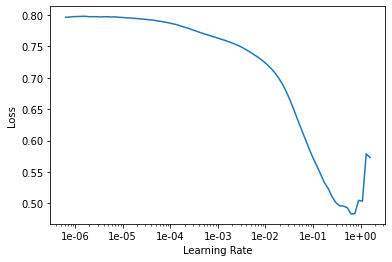

In [102]:
learn.recorder.plot()

In [103]:
l_rate = 1e-01

In [104]:
learn.fit_one_cycle(4, l_rate)

epoch,train_loss,valid_loss,accuracy,time
0,0.021901,0.005679,0.999890,02:49
1,0.020565,0.025658,0.999894,02:50
2,0.019750,0.020925,0.999894,02:49
3,0.017558,0.020922,0.999894,02:52


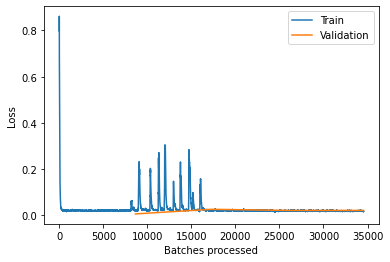

In [105]:
learn.recorder.plot_losses()

In [ ]:
learn.save(path/'ZindiSANRAL_fastai')

In [106]:
predictions, *_ = learn.get_preds(DatasetType.Test)

In [107]:
test['p'] = predictions[:,1]
for t in [0.01, 0.03, 0.035, 0.04, 0.045, 0.05, 0.1, 0.3]:
  test['pt'] = (test['p']>t).astype(int)
  print('Threshold: ', t, 'F1:', f1_score(test['y'], test['pt']))

Threshold:  0.01 F1: 0.02685342045821233
Threshold:  0.03 F1: 0.02767270945614895
Threshold:  0.035 F1: 0.02437964661581539
Threshold:  0.04 F1: 0.022872934673957783
Threshold:  0.045 F1: 0.019450009105809504
Threshold:  0.05 F1: 0.015656817050545273
Threshold:  0.1 F1: 0.0
Threshold:  0.3 F1: 0.0


#### The best results (*f1_score: 0.026 / 0.027*) are very similar to the previous ```notebook```; only without the time intensive ```parameter tuning```. 

> I'm going to stop now. I might be ```overfitting```; but did wrangle some data and hopefully gained a basic understanding of ```machine learning``` with a dose of fastai's deep learning ```tabular``` method. I'll leave the rest to the experts.

> I won't be adding the travel time data... not soon anyway.